*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Title



[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/nb/centrality.ipynb).

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Section

In [3]:

room_names = {
    1: "Lobby",
    2: "Main Stair",
    3: "Living Room",
    4: "Café",
    6: "Shop",
    7: "Garden",
}

In [4]:
# Create graph
G = nx.Graph()
G.add_nodes_from(room_names.values())
edges = [
    ("Lobby", "Living Room"),
    ("Lobby", "Shop"),
    ("Lobby", "Main Stair"),
    ("Living Room", "Main Stair"),
    ("Main Stair", "Café"),
    ("Café", "Garden"),
]
G.add_edges_from(edges)
G

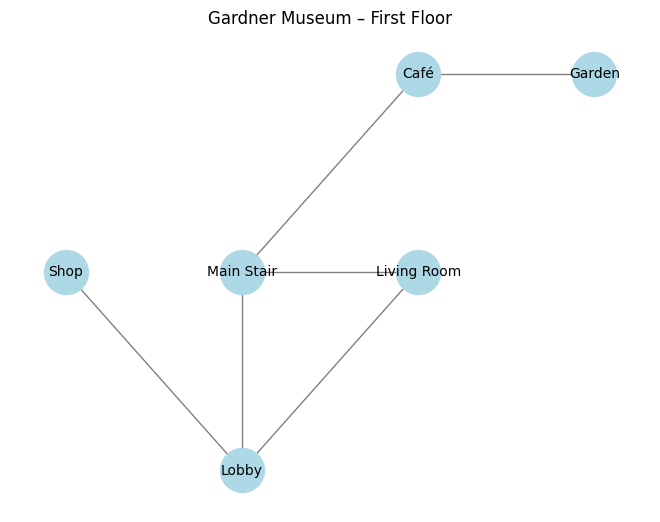

In [5]:
# Approximate positions (manually aligned to floor plan layout)
positions = {
    "Lobby": (0, 0),
    "Main Stair": (0, 1),
    "Shop": (-1, 1),
    "Garden": (2, 2),
    "Living Room": (1, 1),
    "Café": (1, 2),
}

nx.draw(
    G, positions,
    with_labels=True,
    node_color='lightblue',
    node_size=1000,
    font_size=10,
    edge_color='gray'
)
plt.title("Gardner Museum – First Floor")
plt.axis('off')
None

In [6]:
probs = pd.Series(1 / len(G), index=G.nodes)

In [7]:
def update_probs(G, probs):
    new_probs = pd.Series(0.0, index=G.nodes)
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        share = probs[node] / len(neighbors)
        for neighbor in neighbors:
            new_probs[neighbor] += share
        
    return new_probs

In [8]:
for step in range(5):
    probs = update_probs(G, probs)
    print(f"Step {step+1}")
    print(probs.round(3))


Step 1
Lobby          0.306
Main Stair     0.222
Living Room    0.111
Café           0.222
Shop           0.056
Garden         0.083
dtype: float64
Step 2
Lobby          0.185
Main Stair     0.269
Living Room    0.176
Café           0.157
Shop           0.102
Garden         0.111
dtype: float64
Step 3
Lobby          0.279
Main Stair     0.228
Living Room    0.151
Café           0.201
Shop           0.062
Garden         0.079
dtype: float64
Step 4
Lobby          0.213
Main Stair     0.269
Living Room    0.169
Café           0.155
Shop           0.093
Garden         0.100
dtype: float64
Step 5
Lobby          0.267
Main Stair     0.233
Living Room    0.161
Café           0.190
Shop           0.071
Garden         0.077
dtype: float64


In [9]:
nodes = list(G.nodes)
n = len(nodes)
nodes

['Lobby', 'Main Stair', 'Living Room', 'Café', 'Shop', 'Garden']

In [10]:
# Adjacency matrix as a NumPy array
A = nx.to_numpy_array(G, nodelist=nodes)
A

array([[0., 1., 1., 0., 1., 0.],
       [1., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [11]:
adj_df = pd.DataFrame(A, index=nodes, columns=nodes)
adj_df

,Lobby,Main Stair,Living Room,Café,Shop,Garden
Lobby,0.0,1.0,1.0,0.0,1.0,0.0
Main Stair,1.0,0.0,1.0,1.0,0.0,0.0
Living Room,1.0,1.0,0.0,0.0,0.0,0.0
Café,0.0,1.0,0.0,0.0,0.0,1.0
Shop,1.0,0.0,0.0,0.0,0.0,0.0
Garden,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
# Degree vector (row sums)
row_sums = A.sum(axis=1)

# Transition matrix: normalize rows of A
P = A / A.sum(axis=1, keepdims=True)
np.round(P, 3)

array([[0.   , 0.333, 0.333, 0.   , 0.333, 0.   ],
       [0.333, 0.   , 0.333, 0.333, 0.   , 0.   ],
       [0.5  , 0.5  , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.5  , 0.   , 0.   , 0.   , 0.5  ],
       [1.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   , 0.   , 0.   ]])

In [13]:
x = np.ones(n) / n

In [14]:
x = P.T @ x
x

array([0.30555556, 0.22222222, 0.11111111, 0.22222222, 0.05555556,
       0.08333333])

In [15]:
probs = pd.Series(x, index=nodes)
print(probs.round(3))

Lobby          0.306
Main Stair     0.222
Living Room    0.111
Café           0.222
Shop           0.056
Garden         0.083
dtype: float64


In [16]:
def run_random_walk(P, x0, steps=5):
    x = x0.copy()
    for _ in range(steps):
        x = P.T @ x
    return x

# Run 10 steps from uniform start
x0 = np.ones(n) / n
x_final = run_random_walk(P, x0, steps=10)
x_final

array([0.24264664, 0.25800968, 0.16585969, 0.15859225, 0.08562901,
       0.08926273])

In [17]:
# Convert to readable form
final_probs = pd.Series(x_final, index=nodes)
print(final_probs.round(4))

Lobby          0.2426
Main Stair     0.2580
Living Room    0.1659
Café           0.1586
Shop           0.0856
Garden         0.0893
dtype: float64


In [18]:
from scipy.linalg import eig

vals, vecs = eig(P.T)
abs(vals)

array([1.        , 0.70710678, 0.19371294, 0.86037961, 0.70710678,
       0.33333333])

In [19]:
vec = vecs.T[0]
vec / vec.sum()

array([0.25      , 0.25      , 0.16666667, 0.16666667, 0.08333333,
       0.08333333])

In [20]:
nx.pagerank(G, alpha=1.0)

{'Lobby': 0.24999964238148223,
 'Main Stair': 0.25000071523391576,
 'Living Room': 0.1666665281169457,
 'Café': 0.16666581288337595,
 'Shop': 0.08333347188374675,
 'Garden': 0.08333382950053163}

In [21]:
degrees = [G.degree(node) for node in nodes]
degrees / np.sum(degrees)

array([0.25      , 0.25      , 0.16666667, 0.16666667, 0.08333333,
       0.08333333])

## The Louvre

Data from Yoshimura, Yuji, Anne Krebs, and Carlo Ratti. "Network science for museums." Plos one 19, no. 3 (2024): e0300957.

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0300957

S1 Data. Louvre museum network data.

https://doi.org/10.1371/journal.pone.0300957.s001

(CSV)
S2 Data. Metropolitan museum of art network data.

https://doi.org/10.1371/journal.pone.0300957.s002

(CSV)
S3 Data. Museum of fine arts Boston network data.

https://doi.org/10.1371/journal.pone.0300957.s003

(CSV)

In [22]:
from pathlib import Path

museum_files = {
    "Louvre Museum": "pone.0300957.s001.csv",
    "Metropolitan Museum of Art": "pone.0300957.s002.csv",
    "Museum of Fine Arts Boston": "pone.0300957.s003.csv"
}

museum_name = "Museum of Fine Arts Boston"
filename = Path('..') / 'data' / museum_files[museum_name]


In [23]:
# TODO: Download the data

In [24]:
louvre = pd.read_csv(filename, index_col=0)
louvre.columns = louvre.columns.astype(int)
louvre

,1,2,3,4,5,6,7,8,9,10,...,240,241,242,243,244,245,246,247,248,249
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
246,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [25]:
G = nx.from_pandas_adjacency(louvre)

In [26]:
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph has 249 nodes and 312 edges.


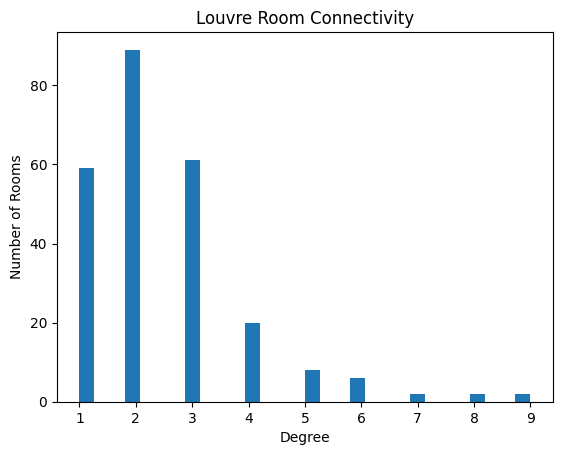

In [27]:
import matplotlib.pyplot as plt

degree_sequence = [d for n, d in G.degree()]
plt.hist(degree_sequence, bins=30)
plt.xlabel("Degree")
plt.ylabel("Number of Rooms")
plt.title("Louvre Room Connectivity")
plt.show()


In [28]:
import networkx as nx
import pandas as pd
import pickle

# Compute layout (this might take a minute or two)
print("Computing layout...")
pos = nx.kamada_kawai_layout(G)  # Or nx.kamada_kawai_layout(G)
print("Layout complete.")

# Save layout using pickle
with open("louvre_layout.pkl", "wb") as f:
    pickle.dump(pos, f)


Computing layout...
Layout complete.


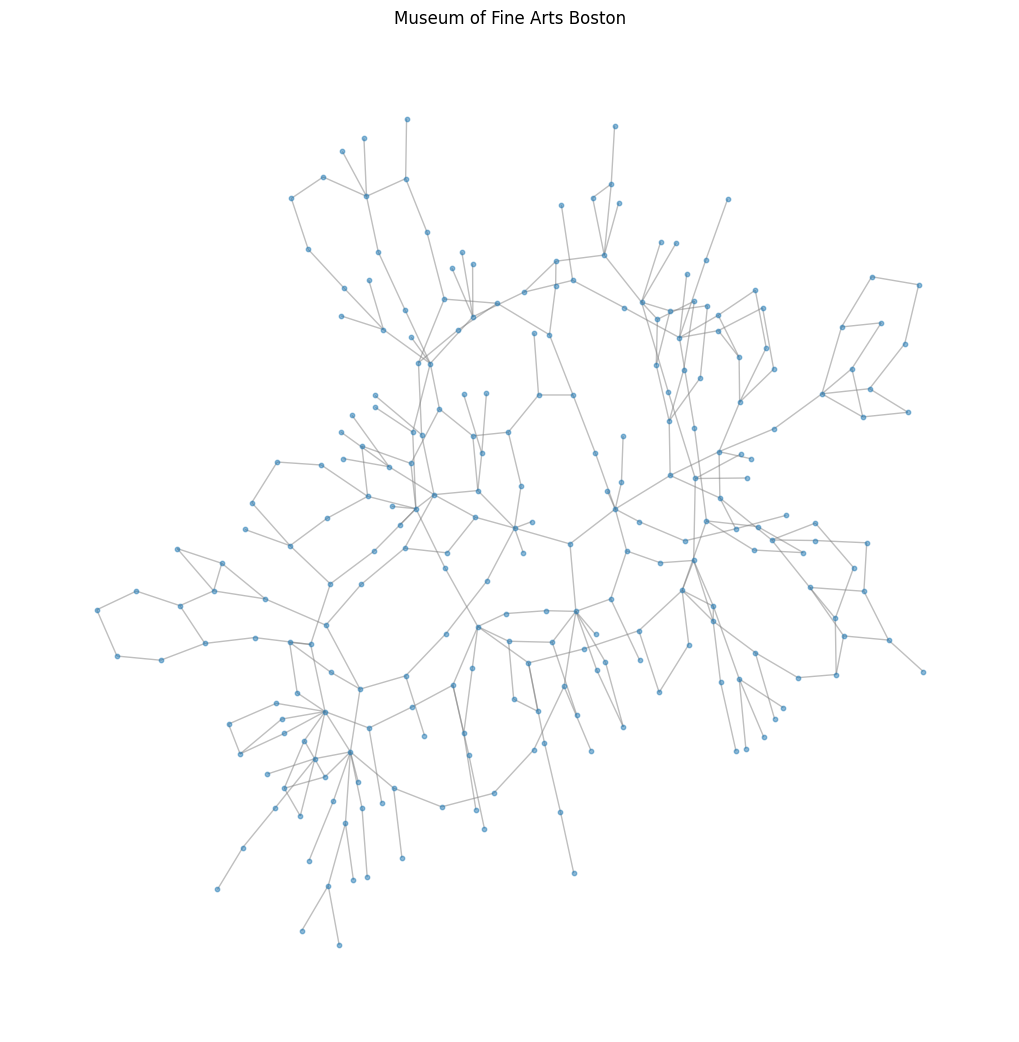

In [29]:
import matplotlib.pyplot as plt
import pickle

# Load layout
with open("louvre_layout.pkl", "rb") as f:
    pos = pickle.load(f)

# Plot using precomputed layout
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, edge_color='gray', alpha=0.5)
plt.title(museum_name)
None

In [30]:
centrality = nx.eigenvector_centrality_numpy(G)


In [31]:
# Sort rooms by centrality score
top_rooms = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 rooms by eigenvector centrality:")
for room, score in top_rooms:
    print(f"Room {room}: {score:.4f}")


Top 10 rooms by eigenvector centrality:
Room 182: 0.4888
Room 82: 0.4691
Room 200: 0.3180
Room 191: 0.2141
Room 237: 0.2101
Room 174: 0.1774
Room 81: 0.1622
Room 190: 0.1509
Room 185: 0.1483
Room 187: 0.1483


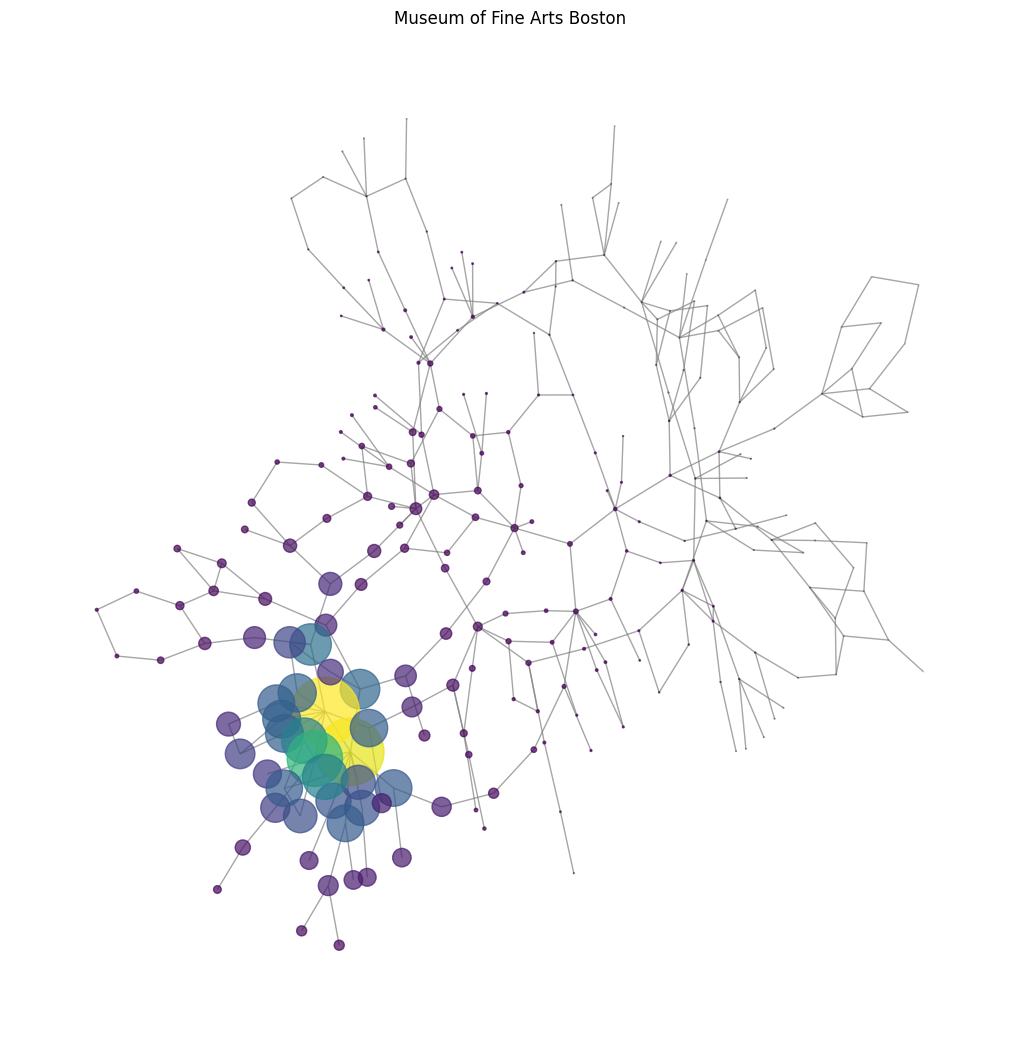

In [33]:
# Use centrality values for node sizes or color
node_sizes = [5000 * centrality[n] for n in G.nodes]
node_colors = [centrality[n] for n in G.nodes]

plt.figure(figsize=(10, 10))
nx.draw(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    edge_color='gray',
    alpha=0.7
)
plt.title(f"{museum_name}")
None

## Discussion

Reformulating Problems in Linear Algebra Terms:

Once we represent the museum as a graph and model movement with a transition matrix $P$, we could simulate the visitor's steps one by one. But we don't have to.

By expressing the problem in linear algebra terms, we can **reduce it to a known problem** — in this case, computing the leading eigenvector of $P$ (or $A$). That tells us the long-run behavior of the system without writing a simulation loop.

This is a recurring theme in the book:  
**Linear algebra turns custom logic into general-purpose computation.**

Instead of writing problem-specific code, we translate the problem into matrix operations — and let fast, well-tested algorithms do the work.


To model a random walk on a graph, we compute a transition matrix $P$ from the adjacency matrix $A$.

**1. Row normalization**

Each row of $A$ is divided by its sum so that the entries in $P$ represent probabilities:

$P = A / \text{row sums}$

This view is intuitive: each node picks a neighbor at random. It's easy to implement and matches the local behavior of the walk.

**2. Matrix equation**

We can also write $D P = A$, where $D$ is a diagonal matrix of degrees:

$P = D^{-1} A$

This version emphasizes structure: $P$ is the result of applying a global transformation. It connects naturally to spectral methods and generalizes well.

**Summary**

- The row-wise view helps with intuition and coding.
- The matrix view highlights structure and generalizes to more advanced models.


[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)